<a href="https://colab.research.google.com/github/ImaneElAssari/LoanPredictionModel/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

`Etape 1` : **Data Cleaning**




In [45]:
#importer les packages
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
#pour la fonction de precision=permet d'valuer le modele
from sklearn.metrics import accuracy_score
#pour la visualisation
import matplotlib.pyplot as pl 
import seaborn as sns
import pickle  #permet  de generer le modele a deployer

In [3]:
#Lire la base de donnes 
df=pd.read_csv('/content/train_u6lujuX_CVtuZ9i.csv')
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [4]:
#Pour afficher toute la base de donnes si on execute df
pd.set_option('display.max_rows',df.shape[0]+1)

**Remarque** :  le **Nna** indique l'existence des données manquantes





In [4]:
#On veut afficher juste les 10  lignes 
pd.set_option('display.max_rows',10)
df

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


Maintenant l'execution de 'df' nous a affiché seulement 10 lignes : les 5 premiers, et les 5 derniers

In [5]:
# afficher les valeurs manquantes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Cette dataset contient 614 enregistrements



In [6]:
df.isnull().sum().sort_values(ascending=False)

Credit_History       50
Self_Employed        32
LoanAmount           22
Dependents           15
Loan_Amount_Term     14
                     ..
Property_Area         0
CoapplicantIncome     0
ApplicantIncome       0
Education             0
Loan_ID               0
Length: 13, dtype: int64

On veut savoir le nombre de valeurs manquantes pour chaque attribut.
On cherche dans la base de données les cases ou il y a une valeur      manqante, on somme toutes ces valeur et puis on applique la méthode sort




In [7]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


count = somme des valeurs de chaque enregistrement


mean = moyenne 


std = ecart-type pour 1er quartile (25%), 2eme(50%), et le 3 eme(75%)

Détermination des valeurs erronées : Si l'on trouve par exemple une valeur qui est inférieur à la min (=150 dans ce cas) alors ça sera une valeur erronée (**outlayer**=valeur qui est à l'écart des autres). Même chose pour le max

In [8]:
#Pour les valeurs categoriques
df.describe(include='O')

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
count,614,601,611,599,614,582,614,614
unique,614,2,2,4,2,2,3,2
top,LP001529,Male,Yes,0,Graduate,No,Semiurban,Y
freq,1,489,398,345,480,500,233,422


In [9]:
#renseigner les valeurs manquantes
#On cree 2 listes(ce sont des listes contenant d'autres listes)
cat_data=[]
num_data=[]
for i,c in enumerate(df.dtypes):#on va classer les attributs selon leur type
   if c==object:
     cat_data.append(df.iloc[:,i])#iloc permet de selctionner toute la colonne
   else:
     num_data.append(df.iloc[:,i])
cat_data

[0      LP001002
 1      LP001003
 2      LP001005
 3      LP001006
 4      LP001008
          ...   
 609    LP002978
 610    LP002979
 611    LP002983
 612    LP002984
 613    LP002990
 Name: Loan_ID, Length: 614, dtype: object, 0        Male
 1        Male
 2        Male
 3        Male
 4        Male
         ...  
 609    Female
 610      Male
 611      Male
 612      Male
 613    Female
 Name: Gender, Length: 614, dtype: object, 0       No
 1      Yes
 2      Yes
 3      Yes
 4       No
       ... 
 609     No
 610    Yes
 611    Yes
 612    Yes
 613     No
 Name: Married, Length: 614, dtype: object, 0       0
 1       1
 2       0
 3       0
 4       0
        ..
 609     0
 610    3+
 611     1
 612     2
 613     0
 Name: Dependents, Length: 614, dtype: object, 0          Graduate
 1          Graduate
 2          Graduate
 3      Not Graduate
 4          Graduate
            ...     
 609        Graduate
 610        Graduate
 611        Graduate
 612        Graduate
 613       

**Remarque :** On peut pas manipuler les deux listes cat_data et num_data, on doit les transformer à des BDD


In [10]:
#transformer nos listes a des BDDs

cat_data=pd.DataFrame(cat_data)
cat_data

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613
Loan_ID,LP001002,LP001003,LP001005,LP001006,LP001008,LP001011,LP001013,LP001014,LP001018,LP001020,LP001024,LP001027,LP001028,LP001029,LP001030,LP001032,LP001034,LP001036,LP001038,LP001041,LP001043,LP001046,LP001047,LP001050,LP001052,LP001066,LP001068,LP001073,LP001086,LP001087,LP001091,LP001095,LP001097,LP001098,LP001100,LP001106,LP001109,LP001112,LP001114,LP001116,...,LP002863,LP002868,LP002872,LP002874,LP002877,LP002888,LP002892,LP002893,LP002894,LP002898,LP002911,LP002912,LP002916,LP002917,LP002925,LP002926,LP002928,LP002931,LP002933,LP002936,LP002938,LP002940,LP002941,LP002943,LP002945,LP002948,LP002949,LP002950,LP002953,LP002958,LP002959,LP002960,LP002961,LP002964,LP002974,LP002978,LP002979,LP002983,LP002984,LP002990
Gender,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,Male,Female,Male,Male,Male,Male,Male,NaN,Male,Male,Male,Male,Male,Female,Male,Male,Male,Male,Male,Male,Male,Female,Male,Male,...,Male,Male,NaN,Male,Male,Male,Male,Male,Female,Male,Male,Male,Male,Female,NaN,Male,Male,Male,NaN,Male,Male,Male,Male,Male,Male,Male,Female,Male,Male,Male,Female,Male,Male,Male,Male,Female,Male,Male,Male,Female
Married,No,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,No,No,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,No,Yes,No,No,Yes,No,Yes,Yes,Yes,No,No,...,Yes,Yes,Yes,No,Yes,No,Yes,No,Yes,Yes,Yes,Yes,Yes,No,No,Yes,Yes,Yes,No,Yes,Yes,No,Yes,No,Yes,Yes,No,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,Yes,No
Dependents,0,1,0,0,0,2,0,3+,2,1,2,2,2,0,2,0,1,0,0,0,0,1,0,2,1,0,0,2,0,2,1,0,1,0,3+,0,0,0,0,0,...,3+,2,0,0,1,0,2,0,0,1,1,1,0,0,0,2,0,2,3+,0,0,0,2,NaN,0,2,3+,0,3+,0,1,0,1,2,0,0,3+,1,2,0
Education,Graduate,Graduate,Graduate,Not Graduate,Graduate,Graduate,Not Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Not Graduate,Graduate,Not Graduate,Graduate,Not Graduate,Graduate,Not Graduate,Not Graduate,Graduate,Graduate,Graduate,Not Graduate,Not Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Not Graduate,...,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Not Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Not Graduate,Not Graduate,Graduate,Graduate,Graduate,Graduate,Not Graduate,Graduate,Graduate,Graduate,Not Graduate,Graduate,Not Graduate,Graduate,Graduate,Graduate,Graduate,Graduate,Graduate
Self_Employed,No,No,Yes,No,No,Yes,No,No,No,No,No,NaN,No,No,No,No,No,No,No,NaN,No,No,No,No,NaN,Yes,No,No,No,NaN,NaN,No,Yes,No,No,No,No,No,No,No,...,No,No,No,No,No,NaN,No,No,No,No,No,No,No,No,No,Yes,No,Yes,Yes,No,Yes,No,Yes,No,Yes,No,NaN,NaN,No,No,No,No,No,No,No,No,No,No,No,Yes
Property_Area,Urban,Rural,Urban,Urban,Urban,Urban,Urban,Semiurban,Urban,Semiurban,Urban,Urban,Urban,Rural,Urban,Urban,Urban,Urban,Rural,Urban,Urban,Urban,Semiurban,Rural,Semiurban,Semiurban,Semiurban,Urban,Urban,Semiurban,Urban,Urban,Rural,Semiurban,Rural,Urban,Urban,Semiurban,Urban,Semiurban,...,Semiurban,Urban,Semiurban,Urban,Rural,Urban,Semiurban,Urban,Semiurban,Rural,Rural,Rural,Urban,Semiurban,Semiurban,Semiurban,Semiurban,Semiurban,Semiurban,Rural,Urban,Rural,Rural,Semiurban,Rural,Urban,Urban,Rural,Urban,Rural,Semiurban,Urban,Semiurban,Rural,Rural,Rural,Rural,Urban,Urban,Semiurban
Loan_Status,Y,N,Y,Y,Y,Y,Y,N,Y,N,Y,Y,Y,N,Y,Y,Y,N,N,Y,N,Y,N,N,N,Y,Y,Y,N,Y,N,N,N,Y,N,Y,N,Y,Y,Y,...,N,Y,N,Y,Y,Y,Y,N,Y,N,N,N,Y,Y,Y,N,Y,N,Y,Y,Y,Y,N,N,Y,Y,N,Y,Y,Y,Y,N,Y,Y,Y,Y,Y,Y,Y,N


La base de données qu'on a obtenue est inversée vue qu’on a appliqué la fonction DataFrame sur la liste cat_data, et donc elle a pris les indices comme étant des attributs. Pour résoudre ce problème on doit utiliser la transposé

In [11]:
cat_data=pd.DataFrame(cat_data).transpose()
cat_data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,Urban,Y
4,LP001008,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...,...
609,LP002978,Female,No,0,Graduate,No,Rural,Y
610,LP002979,Male,Yes,3+,Graduate,No,Rural,Y
611,LP002983,Male,Yes,1,Graduate,No,Urban,Y
612,LP002984,Male,Yes,2,Graduate,No,Urban,Y


In [12]:
#de meme pour la liste des donnees numeriques num_data
num_data=pd.DataFrame(num_data).transpose()
num_data

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849.0,0.0,NaN,360.0,1.0
1,4583.0,1508.0,128.0,360.0,1.0
2,3000.0,0.0,66.0,360.0,1.0
3,2583.0,2358.0,120.0,360.0,1.0
4,6000.0,0.0,141.0,360.0,1.0
...,...,...,...,...,...
609,2900.0,0.0,71.0,360.0,1.0
610,4106.0,0.0,40.0,180.0,1.0
611,8072.0,240.0,253.0,360.0,1.0
612,7583.0,0.0,187.0,360.0,1.0


**Renseigner les valeurs manquantes:**

**Remarque:** Au cas où la valeur manquante ne perturbe pas le modèle ou si on a assez de valeurs dans la BDD, on peut ne pas la renseigner


Pour les valeurs catégoriques : on va remplacer la valeur manquante par la valeur qui se répète le plus (qui a la haute fréquence) exemple gender : on remarque que la catégorie 'Male' est plus fréquente que ‘female’ et donc à chaque fois qu’on trouve une valeur manquante dans le gendre on va la remplacer par 'Male'. Ceci va nous garantir un model non biaisé.


In [13]:
#Cas de valeurs categoriques
cat_data=cat_data.apply(lambda x:x.fillna(x.value_counts().index[0]))#on a remplacer les NNa par la valeur la plus dominante pour chaque attribut
cat_data.isnull().sum().any()

False

In [14]:
#explication: x.value_counts().index[0] 
#value_counts retourne une liste  contenant  le nombre d'occurence de chaque valeur (trie d'une maniere decroissante)
# index[0] prend la valeur la plus frequente
cat_data['Education'].value_counts()

Graduate        480
Not Graduate    134
Name: Education, dtype: int64

Pour les valeurs numériques : on va renseigner la valeur manquante qui se trouve dans un rang (n) comme similaire à la valeur ayant le rang (n-1)

In [15]:
#Cas de valeurs numeriques
num_data.fillna(method='bfill',inplace=True)
num_data.isnull().sum().any()#retourne un boolean qui verifie s'il reste emcore des valeurs manquantes

False

**bdill** : permet de remplacer directement les valeurs manquantes par la valeur précédente de la même colonne

In [16]:
num_data

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,5849.0,0.0,128.0,360.0,1.0
1,4583.0,1508.0,128.0,360.0,1.0
2,3000.0,0.0,66.0,360.0,1.0
3,2583.0,2358.0,120.0,360.0,1.0
4,6000.0,0.0,141.0,360.0,1.0
...,...,...,...,...,...
609,2900.0,0.0,71.0,360.0,1.0
610,4106.0,0.0,40.0,180.0,1.0
611,8072.0,240.0,253.0,360.0,1.0
612,7583.0,0.0,187.0,360.0,1.0


La variable target '**Loan_Status**' est de type string contenant des 'Y/N', on veut les remplacer par 0 et 
1

In [17]:
#Transformer la colonne target
target_value={'Y':1,'N':0}
target=cat_data['Loan_Status']
cat_data.drop('Loan_Status',axis=1,inplace=True)
target=target.map(target_value)#mapage entre Y/1 N/0
target

0      1
1      0
2      1
3      1
4      1
      ..
609    1
610    1
611    1
612    1
613    0
Name: Loan_Status, Length: 614, dtype: int64

On veut maintenant remplacer le reste des valeurs catégoriques par des 0 et des 1 d'une manière automatique. Pour se faire on aura besoin de LabelEncoder qui se trouve dans sklearn

In [18]:
#instantiation de LabelEncoder
le=LabelEncoder()
for i in cat_data:
  cat_data[i]=le.fit_transform(cat_data[i])
cat_data

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,Property_Area
0,0,1,0,0,0,0,2
1,1,1,1,1,0,0,0
2,2,1,1,0,0,1,2
3,3,1,1,0,1,0,2
4,4,1,0,0,0,0,2
...,...,...,...,...,...,...,...
609,609,0,0,0,0,0,0
610,610,1,1,3,0,0,0
611,611,1,1,1,0,0,2
612,612,1,1,2,0,0,2


La colonne LoanId doit être supprimé avant de commencer le traitement des données vue qu'elle n'a aucune utilité au niveau de notre model

In [19]:
#Supprimer loan_id
cat_data.drop('Loan_ID',axis=1,inplace=True)

Maintenant qu’on a préparé nos données numériques et catégoriques, on doit les rassembler dans une seule base de données.

In [20]:
#Concatener cat_data et num_data + specifier la trget
X=pd.concat([cat_data,num_data],axis=1)
Y=target

In [21]:
X

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
0,1,0,0,0,0,2,5849.0,0.0,128.0,360.0,1.0
1,1,1,1,0,0,0,4583.0,1508.0,128.0,360.0,1.0
2,1,1,0,0,1,2,3000.0,0.0,66.0,360.0,1.0
3,1,1,0,1,0,2,2583.0,2358.0,120.0,360.0,1.0
4,1,0,0,0,0,2,6000.0,0.0,141.0,360.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
609,0,0,0,0,0,0,2900.0,0.0,71.0,360.0,1.0
610,1,1,3,0,0,0,4106.0,0.0,40.0,180.0,1.0
611,1,1,1,0,0,2,8072.0,240.0,253.0,360.0,1.0
612,1,1,2,0,0,2,7583.0,0.0,187.0,360.0,1.0


` Etape2` :  **Analyse Exploratoire (EDA)**

In [22]:
#Varibale target 
target.value_counts()

1    422
0    192
Name: Loan_Status, dtype: int64

In [24]:
#La BDD utilisee pour l'EDA
df=pd.concat([cat_data,num_data,target],axis=1)

Le pourcentage des credits accordes est:0.3127035830618892
Le pourcentage des credits non accordes est:0.6872964169381107


/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


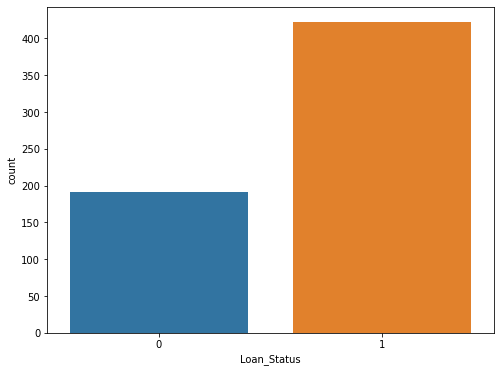

In [23]:
pl.figure(figsize=(8,6))
sns.countplot(target)
yes=target.value_counts()[0]/len(target)
no=target.value_counts()[1]/len(target)
print(f'Le pourcentage des credits accordes est:{yes}')
print(f'Le pourcentage des credits non accordes est:{no}')

On va étudier l'impact de chaque attribut sur l'accord de crédit (On cherche les variables significatives pour notre modèle)

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


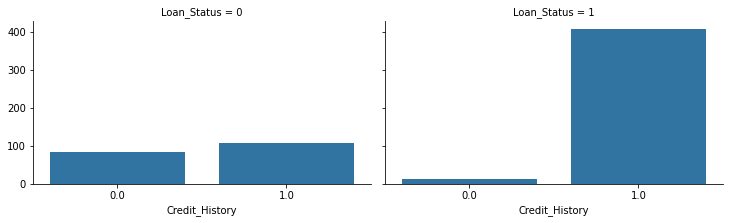

In [26]:
#Credit history
grid=sns.FacetGrid(df,col='Loan_Status',size=3.2,aspect=1.6)
grid.map(sns.countplot,'Credit_History')

On essaye de voir la relation entre le fait d'accorder un crédit et l'historique des crédits du client. On remarque d'après la 2eme figure que si le client avait eu déjà un crédit, la chance de lui accorder un autre augmente.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


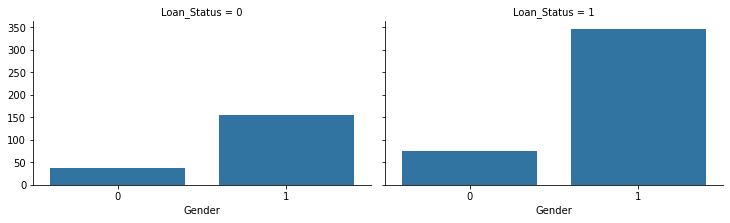

In [27]:
#Gender
grid=sns.FacetGrid(df,col='Loan_Status',size=3.2,aspect=1.6)
grid.map(sns.countplot,'Gender')

Quant à la variable Gender on remarque que les hommes demandent plus de crédits par rapport aux femmes, et donc ils ont plus de chance d'accepter leurs demandes.

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


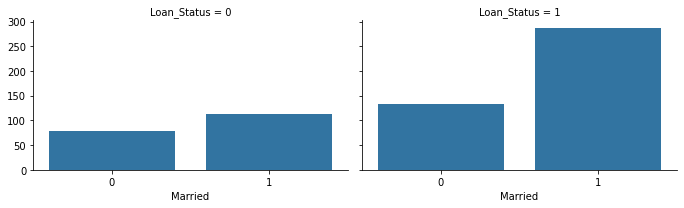

In [33]:
#Married
grid=sns.FacetGrid(df,col='Loan_Status',size=3.0,aspect=1.6)
grid.map(sns.countplot,'Married')

On remarque que le pourcentage des gens mariés et le pourcentage des célibataires est à peu près le même au cas où Loan_Status=0, et donc la variable Married n'est pas significative pour la variable cible (L'écart est relativement faible).

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:645: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


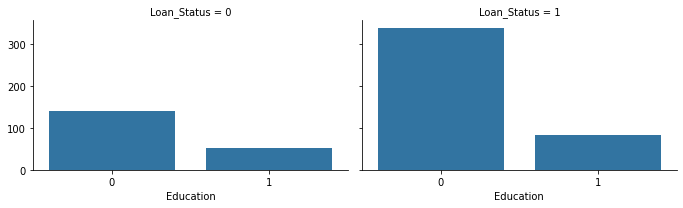

In [34]:
#Education
grid=sns.FacetGrid(df,col='Loan_Status',size=3.0,aspect=1.6)
grid.map(sns.countplot,'Education')

Les gens ayant effectué leurs études ont plus de chance d'avoir un crédit.

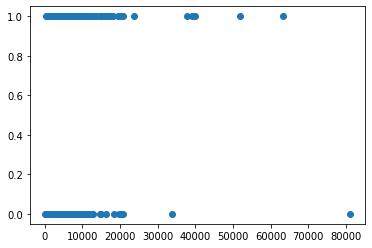

In [36]:
#La varibale revenue du demandeur est de type numerique et donc pour l'afficher on va utiliser scatter
pl.scatter(df['ApplicantIncome'],df['Loan_Status'])


1= crédits acceptes
0= crédits non accordees 
On remarque qu'il n'y a pas de différence significative entre les deux barres et donc la variable ApplicationIncome n'aura pas d'impact sur le modèle


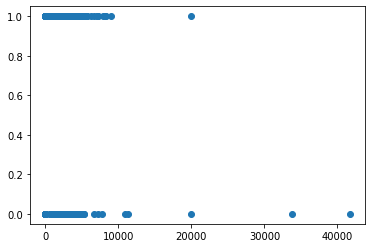

In [37]:
pl.scatter(df['CoapplicantIncome'],df['Loan_Status'])

In [38]:
df.groupby('Loan_Status').median()

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
Loan_Status,,,,,,,,,,,
0,1,1,0,0,0,1,3833.5,268.0,132.5,360.0,1.0
1,1,1,0,0,0,1,3812.5,1239.5,127.5,360.0,1.0


Cette instruction permet de calculer la médiane pour chaque variable (quantitative).On peut comparer la medianne pour savoir si l'attribut est hautement significative pour notre modèle ou non.


**Exemple** : CoapplicantIncome le credit est refusé si le revenue du conjoint 
est bas, alors qu'il est accepté lorsqu'il est haut 

`Etape3:` **Implémentation du Modèle** 

Tout d'abord, on doit diviser notre base de donnees a une partie de training et autre de test.

In [43]:
#Divser la BDD
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)#Initialisation
#cette boucle va faire la devision
for train,test in sss.split(X,Y):
  X_train,X_test=X.iloc[train],X.iloc[test]
  y_train,y_test=Y.iloc[train],Y.iloc[test]
print('X_train taille:',X_train.shape)
print('X_test taille:',X_test.shape)
print('y_train taille:',y_train.shape)
print('y_test taille:',y_test.shape)

X_train taille: (491, 11)
X_test taille: (123, 11)
y_train taille: (491,)
y_test taille: (123,)


On va créer 3 modèles : Logistic Regression, KNN et Decision Tree, puis on va choisir celui ayant la meilleure accuracy(Métrique pour déterminer  la précision de notre modèle)

In [49]:
#Creation du modele
#On va creer un dictionnaire contennat tous nos modeles
models={
     'LogisticRegression':LogisticRegression(random_state=42),
     ' KNeighborsClassifier':KNeighborsClassifier(),
     'DecisionTreeClassifier':DecisionTreeClassifier(max_depth=1,random_state=42)
     }
#Definition de la fonction de precision
def accu(y_true,y_pred,retu=False):
  acc=accuracy_score(y_true,y_pred)
  if retu:
    return acc
  else:
    print(f'La precision du modele est :{acc}')
#Definition de la fonction d'application des 3 modeles
def train_test_eval(models,X_train,y_train,X_test,y_test):
  for name,model in models.items():
    print(name,':')
    model.fit(X_train,y_train)
    accu(y_test,model.predict(X_test))
    print('-'*30)
train_test_eval(models,X_train,y_train,X_test,y_test)

LogisticRegression :
La precision du modele est :0.8536585365853658
------------------------------
 KNeighborsClassifier :
La precision du modele est :0.6504065040650406
------------------------------
DecisionTreeClassifier :
La precision du modele est :0.8455284552845529
------------------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Selon les performances des 3 modèles on remarque que la LogisticRegression représente le modèle le plus précis. (C'est lui qui a la plus haute accuracy)

On va créer une nouvelle base de données qui contient juste les variables significatives et on va appliquer le modèle LogiscticRegression.

In [50]:
#Creation de la nouvelle BDD
X_2=X[['Credit_History','Gender','Married','CoapplicantIncome','ApplicantIncome']]

In [51]:
#Divser la nouvelle BDD
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)#Initialisation
#cette boucle va faire la devision
for train,test in sss.split(X_2,Y):
  X_train,X_test=X_2.iloc[train],X_2.iloc[test]
  y_train,y_test=Y.iloc[train],Y.iloc[test]
print('X_train taille:',X_train.shape)
print('X_test taille:',X_test.shape)
print('y_train taille:',y_train.shape)
print('y_test taille:',y_test.shape)

X_train taille: (491, 5)
X_test taille: (123, 5)
y_train taille: (491,)
y_test taille: (123,)


`X_train taille: (491, 5)`: 5 indique le nombre de colonnes, 419 est le nombre d'enregistrements

In [52]:
train_test_eval(models,X_train,y_train,X_test,y_test)

LogisticRegression :
La precision du modele est :0.8536585365853658
------------------------------
 KNeighborsClassifier :
La precision du modele est :0.6585365853658537
------------------------------
DecisionTreeClassifier :
La precision du modele est :0.8455284552845529
------------------------------


On remarque qu'il n'y a pas une grande différence par rapport aux valeurs qu'on a eues dans le premier modèle. On va donc essayer de créer une autre base de données qui ne contient que les variables hautement significatives

In [53]:
#Creation de la 3emem BDD
X_3=X[['Credit_History','Married','CoapplicantIncome']]

In [54]:
#Division de la BDD
sss=StratifiedShuffleSplit(n_splits=1,test_size=0.2,random_state=42)#Initialisation
#cette boucle va faire la devision
for train,test in sss.split(X_3,Y):
  X_train,X_test=X_3.iloc[train],X_3.iloc[test]
  y_train,y_test=Y.iloc[train],Y.iloc[test]
print('X_train taille:',X_train.shape)
print('X_test taille:',X_test.shape)
print('y_train taille:',y_train.shape)
print('y_test taille:',y_test.shape)

X_train taille: (491, 3)
X_test taille: (123, 3)
y_train taille: (491,)
y_test taille: (123,)


In [55]:
#Application du modele
train_test_eval(models,X_train,y_train,X_test,y_test)

LogisticRegression :
La precision du modele est :0.8536585365853658
------------------------------
 KNeighborsClassifier :
La precision du modele est :0.6991869918699187
------------------------------
DecisionTreeClassifier :
La precision du modele est :0.8455284552845529
------------------------------


On a obtenu la même accuracy au niveau de la Logistic Regression, et donc on va garder ce modèle.